
# <span style="color:blue">*k*-NN Classifier Performance on Wine Quality Dataset</span>

***<span style="color:red">By: Rabindra Nepal</span>***

*Date: Feb 7, 2019*

What is in this notebook?
* Implementation of brute-force k-NN Classifier Model.
* Implementation of all the helper functions, performance measures and data processing functions required.
* Only numpy package is used and no functions from any ML library are used (required functions are implemented).
* The implemented algorithm is tested on __[Wine Quality Dataset](http://archive.ics.uci.edu/ml/datasets/Wine+Quality])__ : winequality-white.csv file.
* The performances of the model in the dataset are analyzed.
* Our implementations are cross-checked and verified the results with that from scikit learn.

In [23]:
# Dependencies
import math
import time
import numpy as np
import pandas as pd

# Plotting: matplotlib
import matplotlib.pyplot as plt
plt.style.use('_classic_test')
%matplotlib inline

# seaborn
import seaborn as sns

# scipy stats
from scipy import stats

# Collections
from collections import Counter

# parallel computing
from joblib import Parallel, delayed
import multiprocessing

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Importing the functions implemented: from files in the current directory.

In [66]:
from metrics import accuracy_score, precision_score, recall_score, f1_score
from metrics import confusion_matrix, roc_curve, roc_auc_score
from metrics import precision_recall_curve

from helper_functions import train_test_split, best_seed, scale_normal

from knn_classifier import KNeighborsClassifier

from cross_validation import kfold_cross_validation

### Working with Wine Dataset

In this section, we will load the white wine dataset and test our brute-force knn model implemented with it.

Since the performance of k-nn model will also depends upon the training and testing set of data - and the splitted dataset depends upon the random state in the shuffle function we will use later, we will start with fixing the random seed so that our performance checks later donot vary in each of the experiments. Before fixing the random seed, let us first look for the seed which gives a relatively better performance (we are doing this experiment because it sometimes significantly affects the performance of the model).

In [26]:
best_seed()

seed:  39034


#### reading data

In [99]:
df = pd.read_csv('./winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### quality $\Rightarrow$ target

Let us change quality (which varies from 0 to 9) to two target classes: bad (0) and good (1) wines.

if quality $\le 5 \rightarrow$ target = 0 

if quality $> 5 \rightarrow$ target = 1

Let us now convert the whole wine dataset into two classes: bad wine (target 0) and good wine (target 1).

In [100]:
df.rename(columns={'quality': 'target'}, inplace=True)
df['target'] = (df['target'] > 5).astype('int8')

####  data description

In [101]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.665169
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,1.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
target                  4898 non-null int8
dtypes: float64(11), int8(1)
memory usage: 425.8 KB


In [40]:
df[df.target == 0].shape, df[df.target == 1].shape

((1640, 12), (3258, 12))

#### shuffling the dataFrame

Here, let us shuffle the data randomly using pd.DataFrame.sample function with random_state = seed that we chose above with simple search. 

In [41]:
df = df.sample(frac=1, random_state=39034)  # used the random seed obtained above

In [42]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
2184,6.4,0.33,0.24,9.8,0.041,29.0,109.0,0.99560,3.29,0.47,10.1,1
4520,5.8,0.31,0.31,7.5,0.052,55.0,230.0,0.99490,3.19,0.46,9.8,0
3378,6.1,0.28,0.27,4.7,0.030,56.0,140.0,0.99042,3.16,0.42,12.5,1
342,6.4,0.26,0.42,9.7,0.044,30.0,140.0,0.99620,3.18,0.47,9.1,1
990,8.6,0.16,0.38,3.4,0.040,41.0,143.0,0.99320,2.95,0.39,10.2,1


####  Pairplots
Let us understand the correlations of the features each other with little further.

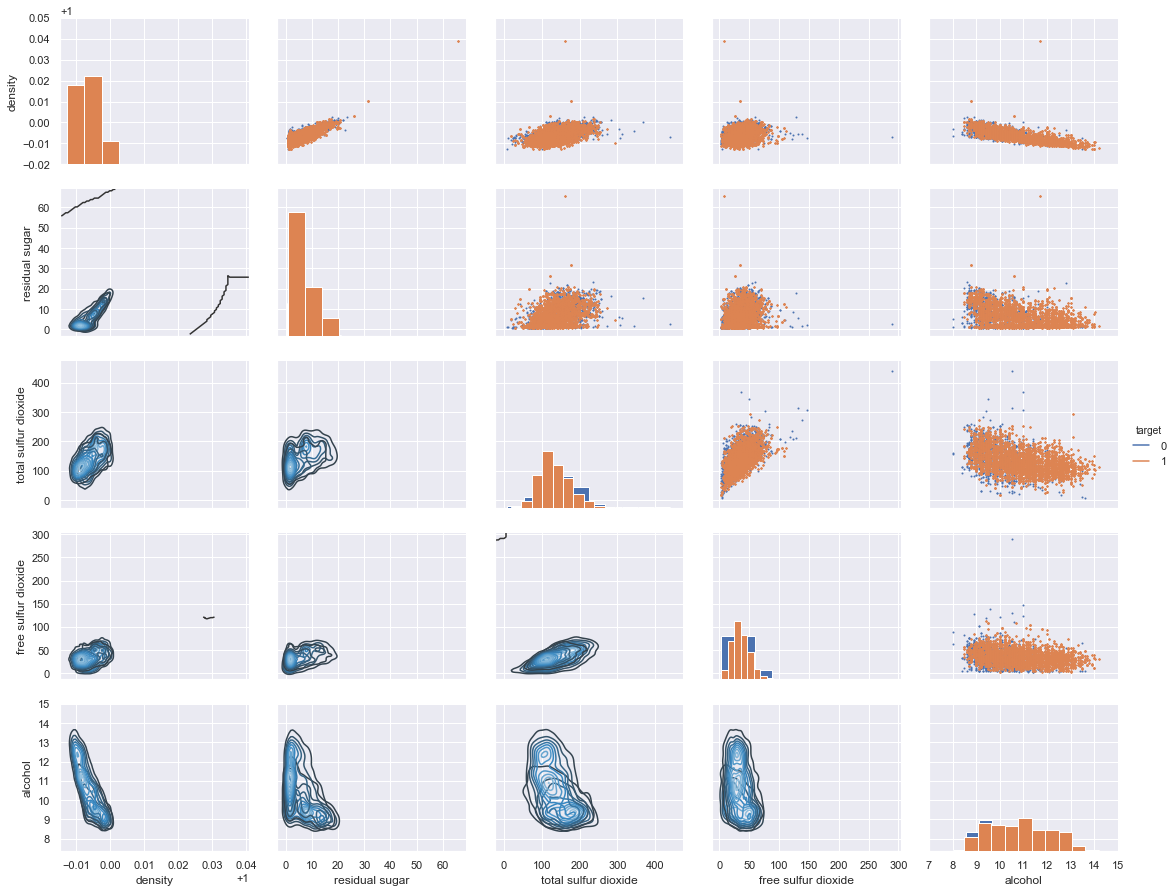

In [43]:
warnings.simplefilter(action='ignore', category=UserWarning)

sns.set(style='darkgrid')

variables = ['density', 'residual sugar', 'total sulfur dioxide', 'free sulfur dioxide', 'alcohol']
g = sns.PairGrid(df, hue='target', vars=variables, 
                 hue_kws={"marker": ["o", "D"], "s": [1, 2]}, aspect=1.25)

g = g.map_diag(plt.hist)
g = g.map_upper(plt.scatter, linewidths=1, s=40)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.add_legend()

#### dropping reduntant features

*Let us first look into correlation of each of the features on the target before dropping any of them.*

In [44]:
df.corr()['target'].abs().sort_values(ascending=False)

target                  1.000000
alcohol                 0.383280
density                 0.268696
volatile acidity        0.225440
chlorides               0.183939
total sulfur dioxide    0.170924
residual sugar          0.092756
fixed acidity           0.089749
pH                      0.083687
sulphates               0.051858
free sulfur dioxide     0.001278
citric acid             0.000700
Name: target, dtype: float64

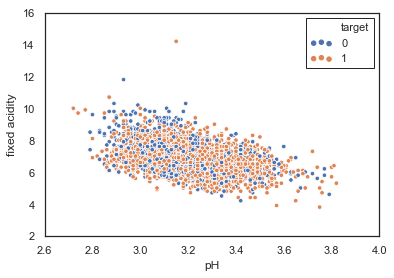

In [45]:
sns.set(style='white')
ax = sns.scatterplot(x="pH", y="fixed acidity",
                     hue="target", data=df)

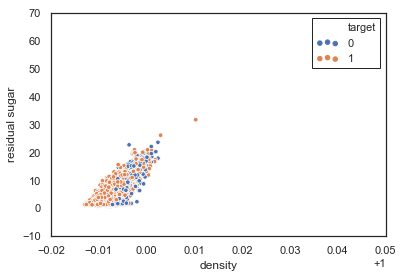

In [46]:
sns.set(style='white')
ax = sns.scatterplot(x="density", y="residual sugar",
                     hue="target", data=df)

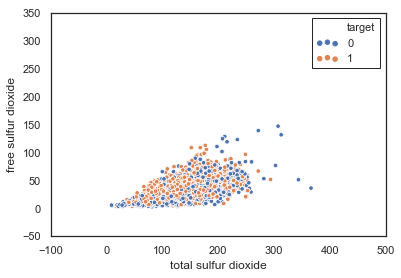

In [47]:
sns.set(style='white')
ax = sns.scatterplot(x="total sulfur dioxide", y="free sulfur dioxide",
                     hue="target", data=df)

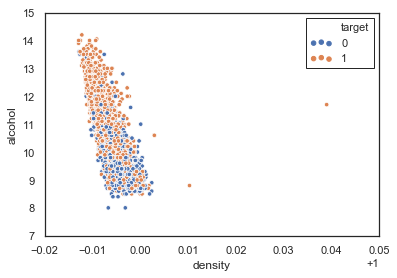

In [48]:
sns.set(style='white')
ax = sns.scatterplot(x="density", y="alcohol",
                     hue="target", data=df)

Here, we checked the performance of the model dropping some of the features for different set of features. Based on those experiments, we ultimately decided to drop ['residual sugar', 'fixed acidity'] at the end - which gives one of the best performances.

In [49]:
# dropping some features

df = df.drop(columns=['residual sugar', 'fixed acidity'], inplace=False)

In [50]:
df.head()

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
2184,0.33,0.24,0.041,29.0,109.0,0.99560,3.29,0.47,10.1,1
4520,0.31,0.31,0.052,55.0,230.0,0.99490,3.19,0.46,9.8,0
3378,0.28,0.27,0.030,56.0,140.0,0.99042,3.16,0.42,12.5,1
342,0.26,0.42,0.044,30.0,140.0,0.99620,3.18,0.47,9.1,1
990,0.16,0.38,0.040,41.0,143.0,0.99320,2.95,0.39,10.2,1


####  partition: training and validation split

In [51]:
y = df['target'].values
X = df.drop(columns=['target'], inplace=False).values

Training - testing data splitting

In [52]:
(x_train, y_train), (x_test, y_test) = train_test_split(X, y, test_size=0.2)

In [53]:
print('training testing data size:')
print('x_train.shape: %s, x_test.shape %s: ' % (x_train.shape, x_test.shape))

training testing data size:
x_train.shape: (3919, 9), x_test.shape (979, 9): 


#### Running the k-NN Classifier model

In [54]:
# setting up model and fitting with train data
knn = KNeighborsClassifier()

# fitting the model
knn.fit(x_train, y_train, k=5, distance_f='euclidean')

In [55]:
# prediction on the test data
start = time.time()
y_pred = knn.predict(x_test, weights='uniform')

print('Time taken for prediction: %f seconds' % (time.time() - start))

Time taken for prediction: 27.739855 seconds


#### Accuracy and F1-score

In [57]:
print('Accuracy (1- GE): ', accuracy_score(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))

Accuracy (1- GE):  0.7436159346271706
F1-score:  0.8158473954512107


### $\color{red}{\text{Cross checking our implementation with scikit learn}}$

In [58]:
from sklearn.neighbors import KNeighborsClassifier as sklearn_KNeighborsClassifier

sk_knn = sklearn_KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform', algorithm='brute')

sk_knn = sk_knn.fit(x_train, y_train)
sk_y_test_pred = sk_knn.predict(x_test)

print('Accuracy/GE: ', accuracy_score(y_test, sk_y_test_pred))
print('F1-score: ', f1_score(y_test, sk_y_test_pred))

Accuracy/GE:  0.7436159346271706
F1-score:  0.8158473954512107


In [59]:
# Results matches with that obtained from scikit learn

#### Standardization of features

In [60]:
# Normalizing/standardizing the features in dataframe df

df = scale_normal(df)

In [62]:
y = df['target'].values
X = df.drop(columns=['target']).values

# splitting into train/validation set
(x_train, y_train), (x_test, y_test) = train_test_split(X, y, test_size=0.2)

#### k-NN model after standardization of features

In [63]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train, k=5, distance_f='euclidean')

start = time.time()
y_pred = knn.predict(x_test, weights='uniform')
print('Time taken for prediction: %f seconds' % (time.time() - start))

Time taken for prediction: 27.900425 seconds


In [67]:
print('Accuracy, (1-GE): ', accuracy_score(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_test_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))

Accuracy, (1-GE):  0.7650663942798774
F1-score:  0.8296296296296296
precision:  0.8151382823871907
recall:  0.8446455505279035


#### Comparision
*Obviously, we have achieved some improvements in the performance of the model followed by the features standardization. Therefore, we will be using normalized/standardized data from here and ahead.*

###### Before Standardization:

* Accuracy (1-GE):  0.7397959
* F1-score:  0.8148148


###### After standardization:

* Accuracy (1-GE):  0.77653061

* F1-score:  0.83932501


#### Inverse distance weighting in k-NN model

Let us now check whether the inverse distance weighting will enhance the performance or not.

In [68]:
# setting up model and fitting with train data

knn = KNeighborsClassifier()
# fitting
knn.fit(x_train, y_train, k=5, distance_f='euclidean')

# prediction on the test data
start = time.time()
y_pred = knn.predict(x_test, weights='distance')

print('Time taken for prediction: %f seconds' % (time.time() - start))

Time taken for prediction: 27.665035 seconds


In [70]:
print('Accuracy (1-GE): ', accuracy_score(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))

Accuracy (1-GE):  0.8161389172625128
F1-score:  0.8664688427299704
precision:  0.8525547445255475
recall:  0.8808446455505279


Clearly, we see the significant increase in the performance of the model followed by the use of inverse distance weights of the neighbors in deciding the nearest neighbors of the test points. Therefore, we will be using it in the further best model evaluations.

### $\color{red}{\text{Cross checking our implementation with scikit learn model}}$

In [71]:
from sklearn.neighbors import KNeighborsClassifier as sklearn_KNeighborsClassifier

sk_knn = sklearn_KNeighborsClassifier(n_neighbors=5, p=2, weights='distance', algorithm='brute')

sk_knn = sk_knn.fit(x_train, y_train)
sk_y_test_pred = sk_knn.predict(x_test)

print('Accuracy/GE: ', accuracy_score(y_test, sk_y_test_pred))
print('F1-score: ', f1_score(y_test, sk_y_test_pred))
print('precision: ', precision_score(y_test, sk_y_test_pred))
print('recall: ', recall_score(y_test, sk_y_test_pred))

Accuracy/GE:  0.8161389172625128
F1-score:  0.8664688427299704
precision:  0.8525547445255475
recall:  0.8808446455505279


Apparently, we have achieved better performance with the inverse distance weighting, see the results above with uniform and distance weights. Therefore, we will be using this methods in calculating the nearest neighbors.

## Model Evaluation

####  k-Fold cross validation on the model

In [72]:
knn = KNeighborsClassifier()

In [73]:
begin = time.time()

model_args = {'k': 5, 'weigths': 'distance', 'distance_f': 'euclidean'}

out = kfold_cross_validation(folds=5, data=x_train, labels=y_train, model=knn, 
                             model_args=model_args, error_function='f1')

print('time to finish job:  ', time.time() - begin)

time to finish job:   15.611213207244873


In [74]:
out

{'expected labels': array([0, 0, 1, ..., 1, 0, 0], dtype=int8),
 'predicted labels': array([1, 1, 0, ..., 1, 0, 0], dtype=int8),
 'errors': array([0.82616822, 0.80234834, 0.82652134, 0.83852691, 0.82652134])}

In [75]:
out['errors'].mean()

0.8240172323080625

####  Best parameters with k-Fold cross-validation

Writing a simple GridSearchCV type of function (brute force search function) to search for best hyperparameters.

In [1136]:
# GridSearchCV to find best hyperparameters
# n_neighbors: list of k's
# weights: list of weights: ['uniform', 'distance']

def GridSearchCV(estimator, ks, weights, distance_fs, error_fun=None):
    # the search look for best case based on the best error_fun score!
    if error_fun is None: error_fun = 'f1'
    best_params = dict(); err = 0.0
    # greedy search for best hyperparameters
    for k in ks:
        for weight in weights:
            for distance_f in distance_fs:
                estimator.k = k
                estimator.weights = weight
                estimator.distance_f = distance_f
                # cross validation with abvoe hyperparameters
                out =  kfold_cross_validation(folds=5, data=x_train, labels=y_train, 
                                              model=estimator, model_args=None, error_function=error_fun)
                # mean performance score from the cross validation
                error = out['errors'].mean()
                # saving the params if improves performance
                if error > err:
                    best_params['k'] = k
                    best_params['weights'] = weight
                    best_params['distance_f'] = distance_f
                    err = error
                    
                    # print the progress
                    print('Best parameters: ', best_params)
                    print('%s score: %f' % (error_fun, error))
    return best_params

In [1137]:
ks = [1, 5, 17, 37]
weights = ['uniform', 'distance']
distance_fs = ['euclidean', 'manhattan']

In [1138]:
begin = time.time()
best_params = GridSearchCV(knn, ks=ks, weights=weights, distance_fs=distance_fs, error_fun='f1')
print('time: ', time.time() - begin)

Best parameters:  {'k': 1, 'weights': 'uniform', 'distance_f': 'euclidean'}
f1 score: 0.836369
Best parameters:  {'k': 1, 'weights': 'uniform', 'distance_f': 'manhattan'}
f1 score: 0.843338
Best parameters:  {'k': 5, 'weights': 'distance', 'distance_f': 'euclidean'}
f1 score: 0.857067
Best parameters:  {'k': 5, 'weights': 'distance', 'distance_f': 'manhattan'}
f1 score: 0.858947
Best parameters:  {'k': 17, 'weights': 'distance', 'distance_f': 'euclidean'}
f1 score: 0.866623
Best parameters:  {'k': 17, 'weights': 'distance', 'distance_f': 'manhattan'}
f1 score: 0.866750
Best parameters:  {'k': 37, 'weights': 'distance', 'distance_f': 'euclidean'}
f1 score: 0.868524
time:  562.0135879516602


#### Best Model Evaluation on Test Data

Here, we test the model with some of the best possible set of hyperparameters and present the results in the Table.2 in the report. We change the parameters slightly to get better performance based on the GridSearchCV hyperparameters tuning results obtained above.

In [76]:
knn = KNeighborsClassifier()

In [77]:
knn.fit(x_train, y_train, k=35, distance_f='euclidean')
y_pred = knn.predict(x_test, weights='distance')

In [78]:
print('Accuracy (1- generalization score): ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))

print('F1-score: ', f1_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))

Accuracy (1- generalization score):  0.8263534218590398
Precision:  0.847672778561354
F1-score:  0.8760932944606413
Recall:  0.9064856711915535


In [79]:
confusion_matrix(y_test, y_pred)

array([[208., 108.],
       [ 62., 601.]])

#### Confidence interval on Generalization Error (GE)


In this section, we now don't fix the dataset and splitting by setting a fixed random seed, rather we will check with different dataset, which can be achieved each time with different random seed during the dataframe shuffling, to calculate the confidence interval on generalization error.

In [90]:
# getting idea about the model performance based on the 
# random seed of df.sample function for data splitting

def generalization_error(seed):
    df = pd.read_csv('./winequality-white.csv', sep=';')
    df.rename(columns={'quality': 'target'}, inplace=True)
    df['target'] = (df['target'] > 5).astype('int8')
    
    # shuffling with random seed: seed
    df = df.sample(frac=1, random_state=seed)
    df = df.drop(columns=['residual sugar', 'fixed acidity'], inplace=False)
    
    # normalization
    df = scale_normal(df)
    
    y = df['target'].values
    X = df.drop(columns=['target'], inplace=False).values
    (x_train, y_train), (x_test, y_test) = partition(X, y, t=0.2)
    
    # we will work with the best model here
    # knn = KNeighborsClassifier()
    # I am using the scikit learn function: because it is much faster with exact same 
    # result as shown above. Here I need to call it for 200 times: takes a lot time with mine
    knn = sklearn_KNeighborsClassifier(n_neighbors=35, p=2, weights='distance')
    
    # fitting the model
    # knn.fit(x_train, y_train, k=5, distance_f='euclidean')
    knn.fit(x_train, y_train)
    
    y_pred = knn.predict(x_test)
    #y_pred = knn.predict(x_test, weights='distance')
    accuracy = accuracy_score(y_test, y_pred)
    ge = 1 - accuracy
    return ge

# generalization errors for 200 samples
# created by different random seeds
def GEs():
    acc = 0.0; fs = 0.0
    ge_list = list()
    for seed in np.random.randint(0, 100000, (200, )):
        ge = generalization_error(seed)
        ge_list.append(ge)
    return ge_list
        
# generalization errors for randomly selected 
# train-test dataset with different seed
ges = GEs()

In [91]:
# Confidence interval 

low_ge = sorted(ges)[4]
high_ge = sorted(ges)[194]
print('95% confidence inverval on ge: {}, {}'.format(low_ge, high_ge))

95% confidence inverval on ge: 0.1489795918367347, 0.19183673469387752


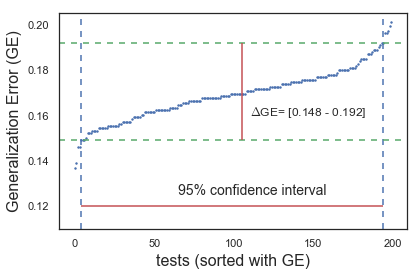

In [93]:
plt.scatter(np.arange(len(ges)), sorted(ges), marker='o', s=2, color='b')
plt.vlines([4, 194], ymin=0.11, ymax=0.21, linestyle='--', color='b')
plt.hlines([low_ge, high_ge], xmin=-10, xmax=209, linestyle='--', color='g')

plt.vlines([105], ymin=low_ge, ymax=high_ge, color='r')
plt.text(110, 0.16, '$\Delta$GE= [0.148 - 0.192]')


plt.hlines([0.12], xmin=4, xmax=194, color='r')
plt.text(65, 0.125, '95% confidence interval', fontsize=14)

#plt.title('95% Confidence interval on GE')
plt.ylabel('Generalization Error (GE)', fontsize=16)
plt.xlabel('tests (sorted with GE)', fontsize=16)
plt.xlim(-10, 209);
plt.ylim(0.11, 0.205);
plt.tight_layout();
plt.savefig('confidence.png', dpi=800);
plt.show()

In the plot above, we plotted the sorted generalization errors for the 200 different samples. The two verticle blue dashed lines contain the 95% of the samples - with the corresponding 95% confidence interval in the generalization errors marked by the horizontal green dashed lines. 

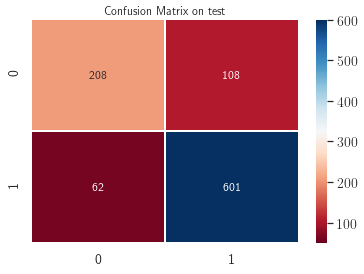

In [103]:
# confusion matrix: illustrating with heatmap

plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='RdBu', vmin=50, vmax=600, linewidths=0.5, fmt=".5g");
plt.title('Confusion Matrix on test');

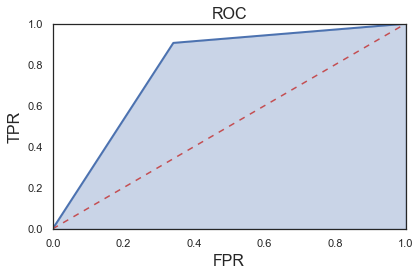

In [82]:
plot_roc_curve(y_test, y_pred)

   With the y_pred of binary classes 0 or 1, we will get only three points in the roc_curve - because of the threshold range that only makes difference at three points. Therefore, we need the probability for each of the classes obtained from the voting in the determination of k-nearest neighbors: predict_proba methods in the KNeighborsClassiier class. See below for that plot.

#### predict_proba with best_params

predict_proba method will give the proability for each of the classes (0 and 1) for each of the test point.

In [83]:
knn = KNeighborsClassifier()

knn.fit(x_train, y_train, k=35, distance_f='euclidean')

# y_score: with predict_proba
y_score = knn.predict_proba(x_test, weights='distance')

In [84]:
import matplotlib
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

#### roc_curve plot

In [91]:
# function to plot roc_curve
def plot_roc_curve(y_true, y_score):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    # for binary classification with y_score = y_test
    # if np.unique(y_score).shape[0] == 2:
    fpr, tpr = list(fpr), list(tpr)
    fpr.insert(0, 0)
    tpr.insert(0, 0)
    
    plt.figure(figsize=(6, 4))
    plt.fill_between(fpr, tpr, y2=0, alpha=0.3, color='b')
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    
    plt.xlabel('FPR', fontsize=16)
    plt.ylabel('TPR', fontsize=16)
    plt.title('ROC', fontsize=16)
    plt.tight_layout()
    plt.show()

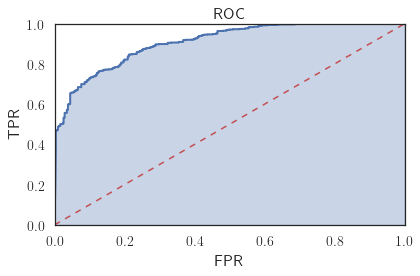

In [92]:
plot_roc_curve(y_test, y_score[:, 1])

#### precision_recall curve

In [97]:
# plotting precision_recall curve
def plot_precision_recall(y_true, y_score):
    ps, rs, _ = precision_recall_curve(y_true, y_score)
    # filling the area under the curve with a color
    plt.fill_between(list(reversed(rs)), list(reversed(ps)), y2=0, alpha=0.25, color='b')
    
    plt.plot(rs, ps, c='b')
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('precision-recall curve')
    plt.tight_layout()
    plt.savefig('precision_recall.png', dpi=600)
    plt.show()

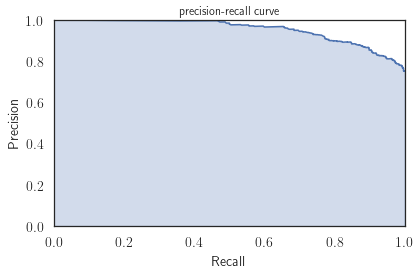

In [98]:
plot_precision_recall(y_test, y_score[:, 1])

<span style="color:red">Done!</span>